# ML Final Project


### Shruti Kotha, Mia Tey, Jeni Pham, and Shruti Patel

## Table of Contents 

1. [Final Project Objective](#Objective)
2. [Part 1. Data Preparation and Data Cleaning for Modeling](#Part-1)
3. [Part 2. Data Exploration](#Part-2)
4. [Part 3. Feature Engineering for Models](#Part-3-Feature-Engineering-for-Models)
5. [Part 4. Data Modeling](#Part-4-Data-Modeling)
5. [Part 5. Outcome and Results](#Outcome)

### Added necessary imports

In [33]:
#add imports
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import warnings

ModuleNotFoundError: No module named 'seaborn'

## Our dataset: 
Our chosen dataset gives information about the Animal Center Outcomes from Oct, 1st 2013 to present. The dataset has 156,218 records and 10 features. Our dataset can be found here: Data.gov: Austin Animal Center Outcomes https://www.google.com/url?q=https://catalog.data.gov/dataset/austin-animal-center-outcomes&sa=D&source=docs&ust=1700010068639490&usg=AOvVaw1x_TF7vgepvCGaLXp_ri01


## Final Project Objective: <a id='Objective'></a>

**Goal:** The primary objective of this project is to assist in predicting the outcomes of new intakes at the Austin Animal Center, with a specific focus on dogs. By leveraging various features such as age, breed, color, animal type, sex upon outcome, outcome subtype, and name, our aim is to develop a predictive model that can categorize outcomes into classes like Foster, Adoption, Transfer, or Euthanize.

**Why We Want to Do This:**

1. **Optimizing Resource Allocation:** Predicting the outcomes of new intakes enables the Austin Animal Center to allocate resources more efficiently. For instance, if we can accurately predict that a certain dog is likely to be adopted quickly, the center can prioritize resources, such as marketing efforts or special adoption events, for other animals that may need more assistance in finding suitable homes.

2. **Enhancing Animal Welfare:** We can ensure that appropriate care and attention are given to animals that might face challenges in finding suitable homes, increasing the chances of positive outcomes for all animals.

3. **Reducing Euthanasia Rates:** If we can identify factors that contribute to positive outcomes such as adoption or fostering, the center can implement targeted strategies to reduce euthanasia rates. We can determine which dogs are more likely to be euthanized and add additional staff to focus on their well being to avoid euthnasia.

**Problems That Can Be Solved by Predicting Outcomes:**

1. **Overcrowding:** Animal shelters often face challenges related to overcrowding. By predicting outcomes, shelters can implement proactive measures to address potential overcrowding issues, such as encouraging adoptions or transfers to partner organizations.

2. **Resource Management:** Limited resources, including staff time, funding, and space, are common issues in animal shelters. Predicting outcomes allows for better resource management, directing efforts toward animals that require more attention and increasing the efficiency of daily operations.

3. **Animal Well-being:** Ensuring the well-being of animals is a fundamental goal for any animal center. We can help create care plans based on the expected duration of stay and the likelihood of adoption, thereby improving the overall quality of life for the animals.

In summary, by developing this prediction model, the Austin Animal Center can enhance its operational efficiency, improve the lives of the animals in its care, and work towards the broader goal of creating a more sustainable and compassionate approach to animal welfare.

## Part 1. Data Preparation and Data Cleaning for Modeling <a id='Part-1'></a>

For this part of the assignment, we read in our data and will perform various data prep techniques like data cleaning and feature engineering to prepare our data for modeling.


In [ ]:
data = pd.read_csv('animaloutcomes.csv', skipinitialspace = True)
data.head()

View the distribution of "Outcome Type". We want to ensure there is sufficient data for each "Outcome Type" and if there isn't we can drop columns as needed.

In [ ]:
outcome_counts = data['Outcome Type'].value_counts()
print(outcome_counts)

First, our label column will be "Outcome Type", since that is what we want to predict. 
If there are any records that lack an entry for "Outcome Type" we drop them.

In [ ]:
print("Length before droping Outcome Type: ", len(data['Outcome Type']))
data = data.dropna(subset=['Outcome Type'])
print("Length after drop Outcome Type: ", len(data['Outcome Type']))

Second, we want to drop unnecessary columns, as many rows of these columns have NaN, and it won't be an important column for us to use in our model.

In [ ]:
data.drop(columns=['Outcome Subtype', 'Name', 'DateTime', 'Date of Birth', 'Animal ID'], inplace=True)
# print the head to ensure only columns important to us are in the dataset
data.head()

Next, we clean up the colors column. Since we plan on using the colors for our models later, we should simplify the categories, as there are way too many unique categories for testing (635).
First, there are entries such as 'black/white' and 'white/black' let's combine these into one label.
Second, there are a lot of unique combinations of two colors. For these records whose combination of color makes up <5% of all colors, add these into one column called 'Multicolor' and jointly categorize it with the 'Tricolor' attribute.

In [ ]:
color_count_before = len(data['Color'].value_counts())
print("Number of unique colors before: ", color_count_before)

# Combine categories such as 'black/white' and 'white/black'
def join_same_color(color):
    color_components = color.split('/')
    color_components.sort()
    return '/'.join(color_components)
data['Color'] = data['Color'].apply(join_same_color)


# Create Multicolor category 
color_counts = data['Color'].value_counts()
color_percent = color_counts / color_counts.sum() * 100
less_than_5_percent = color_percent[color_percent < 1].index
data['Color'] = data['Color'].apply(lambda x: 'Multicolor' if x in less_than_5_percent or x == 'Tricolor' else x)

Next, we decied to create new column for seasons. Given that each month's scope was too broad to determine animal outcomes accurately. We noticed season had more of an impact on animal outtake.

In [ ]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'
    
data['Month'] = pd.to_datetime(data['MonthYear'], format='%b %Y').dt.month
data['Season'] = data['Month'].apply(get_season)
data = data.drop('Month', axis=1)
data.head()

Next, we decieded to categorize each breed into the size of the breed. We noticed our data had too many specific breeds, thus decided to genralize the data. We kept the data of the top most 100 frequent dog breeds and categorized them into their respective size. 

We'll be categorizing the various breeds in the dataset. https://www.trainpetdog.com/dog-breed-size-chart/

In [ ]:

# only keep records that are Dogs
records_to_keep = ['Dog']
dog_data = data[data['Animal Type'].isin(records_to_keep)]

# only keep top 100 most frequent dog breeds in dataset
top_100_breeds = dog_data['Breed'].value_counts().head(100).index
breeds_data = dog_data[dog_data['Breed'].isin(top_100_breeds)]
breeds_data = breeds_data.copy()

# print(top_100_breeds)



# large 70 + lbs avg, small, medium
breed_to_category = {
    'Pit Bull Mix': 'Medium/Large Breeds',
    'Labrador Retriever Mix': 'Medium/Large Breeds',
    'Chihuahua Shorthair Mix': 'Small Breeds',
    'German Shepherd Mix': 'Medium/Large Breeds',
    'Pit Bull': 'Medium/Large Breeds',
    'Australian Cattle Dog Mix': 'Medium/Large Breeds',
    'Chihuahua Shorthair': 'Small Breeds',
    'Labrador Retriever': 'Medium/Large Breeds',
    'German Shepherd': 'Medium/Large Breeds',
    'Dachshund Mix': 'Medium/Small Breeds', 
    'Boxer Mix': 'Medium/Large Breeds',
    'Border Collie Mix': 'Medium/Large Breeds',
    'Miniature Poodle Mix': 'Small Breeds',
    'Siberian Husky Mix': 'Medium Breeds',
    'Australian Shepherd Mix': 'Medium/Large Breeds',
    'Catahoula Mix': 'Medium/Large Breeds',
    'Staffordshire Mix': 'Medium/Large Breeds',
    'Siberian Husky': 'Medium Breeds',
    'Rat Terrier Mix': 'Small Breeds',
    'Great Pyrenees Mix': 'Large Breeds',
    'Yorkshire Terrier Mix': 'Small Breeds',
    'Beagle Mix': 'Medium/Large Breeds',
    'Miniature Schnauzer Mix': 'Medium/Small Breeds',
    'Jack Russell Terrier Mix': 'Medium/Small Breeds',
    'Pointer Mix': 'Large Breeds',
    'Cairn Terrier Mix' : 'Small Breeds',
    'American Bulldog Mix': 'Medium/Large Breeds',                      
    'Chihuahua Longhair Mix': 'Small Breeds',   
    'Anatol Shepherd Mix': 'Medium/Large Breeds',
    'Rottweiler Mix': 'Medium/Large Breeds',
    'Australian Cattle Dog': 'Medium Breeds',
    'Black Mouth Cur Mix': 'Medium/Large Breeds',
    'Plott Hound Mix': 'Medium/Large Breeds',
    'Labrador Retriever/Pit Bull': 'Medium/Large Breeds',
    'Australian Kelpie Mix': 'Medium Breeds',
    'Shih Tzu Mix': 'Small Breeds',
    'Chihuahua Shorthair/Dachshund': 'Small Breeds',
    'Great Pyrenees': 'Large Breeds',
    'American Pit Bull Terrier Mix': 'Medium/Large Breeds',
    'German Shepherd/Labrador Retriever': 'Large Breeds',
    'Dachshund/Chihuahua Shorthair': 'Small Breeds',
    'Labrador Retriever/German Shepherd': 'Large Breeds',
    'American Staffordshire Terrier Mix': 'Medium/Large Breeds',
    'Rottweiler': 'Large Breeds',
    'Boxer': 'Medium/Large Breeds',
    'Shih Tzu': 'Small Breeds',
    'Pit Bull/Labrador Retriever': 'Medium/Large Breeds',
    'Dachshund': 'Small Breeds',
    'Golden Retriever Mix': 'Large Breeds',
    'Maltese Mix': 'Small Breeds',
    'Border Terrier Mix': 'Small Breeds',
    'Miniature Pinscher Mix': 'Small Breeds',
    'Yorkshire Terrier': 'Small Breeds',
    'Blue Lacy Mix': 'Medium/Large Breeds',
    'Doberman Pinsch Mix': 'Medium/Large Breeds',
    'Miniature Poodle': 'Small Breeds',
    'Chow Chow Mix': 'Medium/Large Breeds',
    'American Pit Bull Terrier': 'Medium/Large Breeds',
    'Cairn Terrier': 'Small Breeds',
    'Border Collie': 'Medium/Large Breeds',
    'Queensland Heeler Mix': 'Medium Breeds',
    'Doberman Pinsch': 'Medium/Large Breeds',
    'Basset Hound Mix': 'Medium/Large Breeds',
    'Labrador Retriever/Border Collie': 'Large Breeds',
    'Alaskan Husky Mix': 'Medium/Large Breeds',
    'Pug Mix': 'Small Breeds',
    'Beagle': 'Small Breeds',
    'Pomeranian Mix': 'Small Breeds',
    'Mastiff Mix': 'Large Breeds',
    'Cocker Spaniel Mix': 'Small Breeds',
    'Cardigan Welsh Corgi Mix': 'Medium Breeds',
    'Miniature Schnauzer': 'Small Breeds',
    'Lhasa Apso Mix': 'Small Breeds',
    'Chinese Sharpei Mix': 'Medium/Large Breeds',
    'Australian Shepherd': 'Medium/Large Breeds',
    'Labrador Retriever/Australian Cattle Dog': 'Medium/Large Breeds',
    'Black/Tan Hound Mix': 'Medium/Large Breeds',
    'Pug': 'Small Breeds',
    'Chihuahua Longhair': 'Small Breeds',
    'Great Dane Mix': 'Large Breeds',
    'Boston Terrier Mix': 'Small Breeds',
    'Border Collie/Labrador Retriever': 'Large Breeds',
    'Labrador Retriever/Great Pyrenees' : 'Large Breeds',
    'Dachshund Wirehair Mix' : 'Small Breeds',
    'Dachshund Longhair Mix' : 'Small Breeds',
    'Alaskan Husky' : 'Medium/Large Breeds',
    'Flat Coat Retriever Mix' : 'Large Breeds',
    'Manchester Terrier Mix' : 'Small Breeds',
    'Toy Poodle Mix' : 'Small Breeds',
    'American Bulldog' : 'Medium/Large Breeds',
    'Rat Terrier' : 'Small Breeds',
    'Collie Smooth Mix' : 'Medium/Large Breeds',
    'Maltese' : 'Small Breeds',
    'Anatol Shepherd' : 'Medium/Large Breeds',
    'Staffordshire' : 'Medium/Large Breeds',
    'Belgian Malinois Mix' : 'Medium/Large Breeds',
    'Pit Bull/Boxer' : 'Medium/Large Breeds',
    'Norfolk Terrier Mix' : 'Small Breeds',
    'Australian Cattle Dog/Labrador Retriever' : 'Medium/Large Breeds',
    'Rhod Ridgeback Mix' : 'Large Breeds'         
}
print()
print("Distribution based on size of breed:")

categories = [breed_to_category.get(breed) for breed in breeds_data['Breed']]

category_counts = Counter(categories)

# make sure there is still sufficent data for each size of the animal
for category, count in category_counts.items():
    print(f'{category}: {count}')

# to do add a size category with the breed to wsize mapping
breeds_data.loc[:, 'Size'] = breeds_data['Breed'].map(breed_to_category)
dog_data = breeds_data


# make sure there is a new Size column that reflects the size of the breed for that animal
dog_data.head()


## Part 2. Data Exploration <a id='Part-2'></a>

In this section, we will explore the data to gain insights and better understand its characteristics.

We will be graphing data distributions as part of data exploration. We will be looking for any imbalances, outliers, or anything that could potentially skeww the results of our data. We will then correct that before modeling.

Plot distribution of colors:

In [ ]:
color_counts = dog_data['Color'].value_counts()
color_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Colors')
plt.show()

Display of distribution of season and outcome

In [ ]:
season_counts = dog_data['Season'].value_counts()
season_counts.plot(kind='bar')
plt.title('Frequency of Seasons within dataset')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.show()

outcome_by_season = pd.crosstab(dog_data['Season'], dog_data['Outcome Type'])
outcome_by_season.plot(kind='bar', stacked=True)
plt.title('Outcomes by Season')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

plt.show()


Distribution of dog breed sizes for the top 100 breeds in the dataset.  

In [ ]:
category_labels = [label for label, value in category_counts.items() if label is not None]
category_values = [value for label, value in category_counts.items() if label is not None]


plt.figure(figsize=(10, 6))
plt.bar(category_labels, category_values)
plt.title('Distribution of Dog Breeds by Category')
plt.xlabel('Category')
plt.ylabel('Count')

plt.xticks(rotation=45)

plt.show()

Distribution of dog Males vs Females.

In [ ]:
sex_upon_outcome = dog_data["Sex upon Outcome"]

male = 0
female = 0

for outcome in sex_upon_outcome:
    if pd.notna(outcome):
        if "Male" in outcome:
            male += 1
        elif "Female" in outcome:
            female += 1

        
categories = ["Male", "Female"]
counts = [male, female]

plt.bar(categories, counts)
plt.title("Distribution of Male and Female")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

print(f"Number of Males: {male}")
print(f"Number of Females: {female}")



Distrubtion of nuetured vs spayed at outcome.

In [ ]:
neutered = 0
spayed = 0
intact = 0

sex_counts = dog_data["Sex upon Outcome"].value_counts()
print(sex_counts)

for outcome in sex_upon_outcome:
    if pd.notna(outcome):
        if "Neutered" in outcome:
            neutered += 1
        elif "Spayed" in outcome:
            spayed += 1
        elif "Intact" in outcome: 
            intact += 1
        
categories = ["Neutered", "Spayed", "Intact"]
counts = [neutered, spayed, intact]

plt.bar(categories, counts)
plt.title("Distribution of Neutered, Spayed, or Intact")
plt.xlabel("Sterilization Status")
plt.ylabel("Count")
plt.show()

print(f"Number of Neutered: {neutered}")
print(f"Number of Spayed: {spayed}")
print(f"Number of Intact: {intact}")


Distribution of Months when animals were registered

In [ ]:
month_data = dog_data['MonthYear']
df = pd.DataFrame(month_data)
pattern = r'([a-zA-Z]{3}) \d{4}'
df['MonthYear'] = df['MonthYear'].str.extract(pattern)
# print(df)
data.head()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month_counts = df['MonthYear'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, order=month_order)
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



Convert the age upon outcome into months so all ages are generalized and then plot the distribution.

In [ ]:
def convert_to_months(age_str):
    # Split the age string into value and unit
    value, unit = age_str.split()
    value = int(value)
    
    if 'year' in unit or 'years' in unit:
        return value * 12
    elif 'month' in unit or 'months' in unit:
        return value
    elif 'week' in unit or 'weeks' in unit:
        return value // 4  # Approximate conversion: 1 month = 4 weeks
    elif 'day' in unit or 'days' in unit:
        return value // 30 # Approximate conversion: 1 month = 30 days
    else:
        return 0  # default case

age_data = dog_data['Age upon Outcome']
df = pd.DataFrame(age_data)
df['Age upon Outcome'] = df['Age upon Outcome'].fillna('0 days')  #  fills NaN with '0 days'
# Apply the conversion function to the column
df['Age upon Outcome'] = df['Age upon Outcome'].apply(convert_to_months)
# print(df.head())

mean_age = df['Age upon Outcome'].mean()
median_age = df['Age upon Outcome'].median()
mode_age = df['Age upon Outcome'].mode()
age_df = df

print(f"Mean Age (in months): {mean_age:.2f}")
print(f"Median Age (in months): {median_age:.2f}")
print(f"Mode Age (in months): {mode_age.iloc[0]}")  

age_counts = df.loc[(df['Age upon Outcome'] >= 0) & (df['Age upon Outcome'] <= 228), 'Age upon Outcome'].value_counts().sort_index()
age_counts.plot(kind='bar', figsize=(12,6))
plt.title('Distribution of Ages in Months')
plt.xlabel('Age (in months)')
plt.ylabel('Frequency')
plt.show()





In [ ]:
# remove any negative ages
df = df[df['Age upon Outcome'] >= 0]

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Age upon Outcome'])
plt.xlabel('Age upon Outcome')
plt.ylabel('Frequency')
plt.title(f'Box-and-Whisker Plot')
plt.show()
q1 = df['Age upon Outcome'].quantile(0.25)
q3 = df['Age upon Outcome'].quantile(0.75)
iqr = q3 - q1
print(f"50% of dog's ages in the dataset are between: {q1} and {q3} months")


## Part 3. Feature Engineering for Models <a id='Part-3-Feature-Engineering-for-Models'></a>
We want to numerically represent our data for ease and accuracy of modeling prior to inserting them into our models. First we need to drop additional columns that will not be used in our models.

In [ ]:
# drop the columns we don't need for our models
dog_data.drop(columns=['Animal Type', 'MonthYear', 'Breed'], inplace=True)
dog_data.head()

#### Age: Years to Months
Change age to be uniformly described by months. 

In [ ]:
dog_data = dog_data.drop(columns=['Age upon Outcome'])
dog_data = pd.concat([dog_data, df.iloc[:, 0]], axis=1)
dog_data = dog_data[dog_data['Age upon Outcome'] >= 0]
dog_data.head()

#### Encode Sex and Color: 
This code performs one-hot encoding on the categorical columns 'Sex upon Outcome' and 'Color' in the 'dog_data' DataFrame, creating binary columns for each category. The encoded columns are then concatenated with the original DataFrame, and the original categorical columns are dropped, resulting in a DataFrame with expanded feature representations for 'Sex upon Outcome' and 'Color'.

In [ ]:
encoded_sex = pd.get_dummies(dog_data['Sex upon Outcome'], prefix='Sex upon Outcome').astype(int)
encoded_colors = pd.get_dummies(dog_data['Color'], prefix='Color').astype(int)
dog_data = pd.concat([dog_data, encoded_sex, encoded_colors], axis=1)
dog_data = dog_data.drop(columns=['Color', 'Sex upon Outcome'])
dog_data.head()

#### Encode Size: 
This code snippet encodes the 'Size' column in the 'dog_data' DataFrame ordinally based on predefined size categories. It creates a new column named 'Breed size' where each dog's size is represented by an ordinal encoding, and subsequently, the original 'Size' column is dropped from the DataFrame. 

In [ ]:
# encode breeds ordinally
sizes = ['Small Breeds', 'Medium/Small Breeds', 'Medium/Large Breeds', 'Large Breeds']

size_encode_mapping = {
    'Small Breeds': 1,
    'Medium/Small Breeds': 2,
    'Medium Breeds': 3,
    'Medium/Large Breeds': 4,
    'Large Breeds': 5
}

dog_data['Breed size'] = dog_data['Size'].map(size_encode_mapping)
dog_data = dog_data.drop(columns=['Size'])


dog_data.head()

#### Encode Season: 
This code snippet encodes the 'Season' column in the 'dog_data' DataFrame cyclically using sine and cosine functions. It creates two new columns, 'Season_cos' and 'Season_sin', which represent the cyclic encoding of seasons. The original 'Season' column and an intermediate numeric encoding column are then dropped from the DataFrame, resulting in a dataset where seasons are represented as cyclical features through trigonometric functions.

In [ ]:
import numpy as np

## encode seasons cyclically with sine and cosine functions
season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
dog_data['Season_numeric_encode'] = dog_data['Season'].map(season_mapping)
dog_data['Season_cos'] = np.cos(2 * np.pi * dog_data['Season_numeric_encode'] / 4)
dog_data['Season_sin'] = np.sin(2 * np.pi * dog_data['Season_numeric_encode'] / 4)
dog_data = dog_data.drop(columns=['Season', 'Season_numeric_encode'])
dog_data.head()

## Part 4. Data Modeling <a id='Part-4-Data-Modeling'></a>

#### 1. Naive Bayes: 
Pros: Fast and simple, scalable (performs well on large datasets such as this one), avoids issues with curse of dimensionality
Cons: Independence assumption may not always hold true (ex: size and age may correlate)
#### 2. Decision Tree:
Pros: Computationally inexpensive, robust in presence of outliers, easy to interpret
Cons: Could lead to data fragmentation (overfitting)
#### 3. KNN:
Pros: Easy to implement, can use measures to reduce class imbalance
Cons: Computationally inexpensive to classify a test record, curse of dimentionality, feature selection has large impact on results
#### 4: SVM: 
Pros: Not succeptible to curse of dimensionality, known algorithms to arrive at optimal solution, 
Cons: Hyperparameters need to be tuned well, computationally expensive
#### 5: Ensembling - Random forests & boosting:
Pros: Agregates predictions of multiple classifiers to potantially improve accuracy
Cons: Expensive, only works if all base classifiers perform better than 50% accuracy

### Model 1. Naive Bayes
First, we are using Naive Bayes on our data. We started with this because it is a fast and simple algorithm, scalable (performs well on large datasets such as this one), and avoids issues with curse of dimensionality. 
The data has already been cleaned and engineered, so all we have to do is set the label and features variables.

In [ ]:
#set label col to Outcome Type
label = dog_data['Outcome Type']
label = label.values.ravel()
features= dog_data.drop(['Outcome Type'],axis=1)


#verify we have correct columns
# NB_df.head()
dog_data.head()

 Next, create a Multinomial Naive Bayes classifier (since it supports categorical target 
variables) and perform a 10-fold cross validation on the classifier. 
Print accuracy.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")

# verify shape is correct for NB model
print(dog_data.shape)
print(label.shape)

# normalize and scale features
features = pd.DataFrame(features)
label = pd.DataFrame(label)
le = LabelEncoder()
features = features.apply(le.fit_transform)
label = label.apply(le.fit_transform)

scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# finally model data and check accuracy
mnb = MultinomialNB()
mnb_CV = cross_val_score(mnb, features, label, cv=10)
print('Accuracy: ', mnb_CV.mean())

warnings.resetwarnings()

In [ ]:
from sklearn.metrics import confusion_matrix

# class_names = np.unique(dog_data['Outcome Type'])
# cm = confusion_matrix(label, pred)
# sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix for Naive Bayes')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

Unfortunately, the independence assumption may not always hold true in Naive Bayes (ex: size and age may correlate). Thus we try using decision tree model. 

### Model 2. Decision Tree

Next, we will create a Decision Tree. We chose this model next because it is computationally inexpensive and easy to interpret (similar to naive bayes). However, unlike naive bayes, it is robust in presence of outliers, which will hopefully improve our accuracy rate. 

We implemented hyperparameter optimization for a Decision Tree classifier using a grid search strategy to find the identify the most effective combination of hyperparameters—specifically, the maximum depth of the Decision Tree (`max_depth`) and the number of splits in the StratifiedKFold cross-validator (`n_splits`). Further, a cross-validation was implemented to ensure the best split of the dataset.

The script tracks the best hyperparameter values by comparing mean accuracies. The split that yields the best accuracy has max_depth of 10 and N-splits of 40. The best overall accuracy is 0.62.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_text
import numpy as np
import warnings
warnings.filterwarnings("ignore")

X = dog_data.drop('Outcome Type', axis=1)
y = dog_data['Outcome Type']

# max_depth and n_splits we want to try
max_depth_values = [5, 10, 15, 20]
n_splits_values = [10, 20, 30, 40]

best_mean_accuracy = 0
best_max_depth = None
best_n_splits = None

# iterate over max_depth and n_splits values
for max_depth in max_depth_values:
    for n_splits in n_splits_values:
        dt_model = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=2)
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # perform cross-validation
        cv_scores = cross_val_score(dt_model, X, y, cv=cv, scoring='accuracy')
        mean_accuracy = np.mean(cv_scores)

        # update the best parameters if the current combination is better
        if mean_accuracy > best_mean_accuracy:
            best_mean_accuracy = mean_accuracy
            best_max_depth = max_depth
            best_n_splits = n_splits

# print the best hyperparameters and mean accuracy
print("Best Max Depth:", best_max_depth)
print("Best N_splits:", best_n_splits)
print("Best Mean Accuracy:", best_mean_accuracy)

Unfortunately decision trees are succeptible to data fragmentation (overfitting) and are sensitive to class imbalance. Thus we attempted to improve accuracy by trying out KNN. 

### Model 3: K-Nearest Neighbor

The K-nearest neighbor modeling is an algorithm that's simple to understand and implement. It's simplicity and high accuracy potential is why we decided to use it to model our dataset. However, there are various additional considerations we must take into account when using KNN. 

In cases where a class inbalance exists, KNN is prone to break down. In our case, we have certain class labels that dominate our data. For example, the majority of our outcome instances are adoption, return to owner, and transfer. These outcomes are only three out of nine potential outcomes but make up about 95% of the outcome types in our data. We need to institute a measure to combat against this imbalance. Using weighted voting for our model will prevent the class imbalance from harming our results. In our grid search, weighted and uniform vote will be one of our parameters to see which hyperparameter leads to the better results. This will check for class imbalances worsening our model accuracy. We will also hypertune our parameter K to find a K value that fits our data well and can generalize to new data points too, avoiding overfitting or underfitting. 

Here we're training KNN Model. Grid search will allow us to optimize for our paramaters. We also want to scale our data before training the model since the KNN's algorithm is based on distance and we want to make sure each feature's distances are on the same scale. 



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

# seperate features & labels
features = dog_data.drop('Outcome Type', axis=1)
labels = dog_data['Outcome Type']

# KNN with 80-20 train/test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
x_test = np.ascontiguousarray(x_test)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_test_scaled = np.ascontiguousarray(x_test_scaled)


#initialize parameter grid to find best parameters
param_grid = {
    'n_neighbors': range(3, 25),
    'weights': ['uniform', 'distance']
}

#create knn classifier 
KNN_classifier = KNeighborsClassifier()

# search for best parameters
grid_search = GridSearchCV(KNN_classifier, param_grid, cv=4, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for KNN model:", best_params)

warnings.resetwarnings()


Calculate the accuracy for the model

In [ ]:
from sklearn.metrics import classification_report

print("Best Cross-Validated Accuracy:", grid_search.best_score_)

# calculate accuracy using best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy for each trial:", accuracy)
avg_test_scores = grid_search.cv_results_['mean_test_score']
print(avg_test_scores)

# get classfification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:\n", report)

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = np.unique(dog_data['Outcome Type'])
cm = confusion_matrix(labels, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Model 4: SVM

Next, we decided to go with using an SVM to model our dataset. Because it isn't succeptible to curse of dimensionality (like KNN is), and there are known algorithms to arrive at optimal solution (unlike decision trees which use a greedy approach).

For this model, use logistic regression and randomized search to improve computational speeds.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings("ignore")

param_grid = {
    'C': [0.1, 10],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'max_iter': [500], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] 
}

simple_model = LogisticRegression()
rand_search = RandomizedSearchCV(simple_model, param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1, n_iter=10)
rand_search.fit(x_train, y_train)

# evaluate
y_pred = rand_search.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Logistic Regression model with Randomized Search: ", accuracy)
print(classification_report(y_test, y_pred))
warnings.resetwarnings()

SVMs are computationally expensive, so implementing logistic regression and randomized search instead of using kernel methods and grid search may yield better results but would take more computational effort than feasible by our personal computers.

### Model 5 Ensembling: (can move this later)
Let's try ensembling with random forests. We decided to go with this model because ensembling base classifiers usually performs better because it combines the predictions of multiple base classifiers. 

#### Random forests: 
Let's use a GridSearchCV with a 3-fold CV and try 15, 25, and 50 base classifiers of fully grown decision trees and see which performs best. Then wrap the GridSearchCV in a cross_val_predict with 5-fold CV and display the classification report.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
warnings.filterwarnings("ignore")

label = label.values.ravel()
rf = RandomForestClassifier()

parameter = {
    'n_estimators': [15, 25, 50]
}
grid = GridSearchCV(rf, parameter, cv=3)
pred = cross_val_predict(grid, features, label, cv=5)
# CV_score = cross_val_score(grid, features, label, cv=5)
# print('Accuracy: ', CV_score.mean())
print('Classification Report: \n', classification_report(label, pred))
warnings.resetwarnings()

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = np.unique(dog_data['Outcome Type'])
cm = confusion_matrix(label, pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Boosting: 
Let's use a GridSearchCV with a 3-fold CV and try 15, 25, and 50 base classifiers of decision stumps. Then wrap the GridSearchCV in a cross_val_predict with 5-fold CV and display the classification report.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
warnings.filterwarnings("ignore")

boost = AdaBoostClassifier()
parameter = {
    'n_estimators': [15, 25, 50]
}
grid = GridSearchCV(boost, parameter, cv=3)
pred = cross_val_predict(grid, features, label, cv=5)
print('Classification Report: \n', classification_report(label, pred))
warnings.resetwarnings()

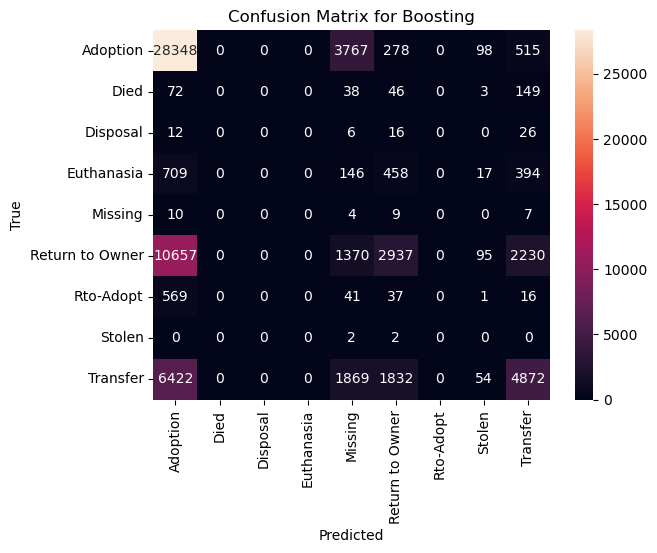

In [29]:
from sklearn.metrics import confusion_matrix

class_names = np.unique(dog_data['Outcome Type'])
cm = confusion_matrix(label, pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Outcome and Results <a id='Outcome'></a>

In [35]:
# Analyze the outcome here